In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!kaggle datasets download -d ashkhagan/figshare-brain-tumor-dataset

100% 838M/839M [00:41<00:00, 19.1MB/s]
100% 839M/839M [00:41<00:00, 21.1MB/s]


In [ ]:
! unzip figshare-brain-tumor-dataset.zip

Archive:  figshare-brain-tumor-dataset.zip
  inflating: dataset/README.txt      
  inflating: dataset/cvind.mat       
  inflating: dataset/data/1.mat      
  inflating: dataset/data/10.mat     
  inflating: dataset/data/100.mat    
  inflating: dataset/data/1000.mat   
  inflating: dataset/data/1001.mat   
  inflating: dataset/data/1002.mat   
  inflating: dataset/data/1003.mat   
  inflating: dataset/data/1004.mat   
  inflating: dataset/data/1005.mat   
  inflating: dataset/data/1006.mat   
  inflating: dataset/data/1007.mat   
  inflating: dataset/data/1008.mat   
  inflating: dataset/data/1009.mat   
  inflating: dataset/data/101.mat    
  inflating: dataset/data/1010.mat   
  inflating: dataset/data/1011.mat   
  inflating: dataset/data/1012.mat   
  inflating: dataset/data/1013.mat   
  inflating: dataset/data/1014.mat   
  inflating: dataset/data/1015.mat   
  inflating: dataset/data/1016.mat   
  inflating: dataset/data/1017.mat   
  inflating: dataset/data/1018.mat   
  infla

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.utils import make_grid
import os
import random
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,InputLayer,Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import h5py
from keras import layers
import keras
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import f1_score,confusion_matrix,roc_curve, roc_auc_score,accuracy_score,precision_score,recall_score

In [ ]:
datadir="/content/dataset/data"
N=3064
traindata=[]

for i in range(1,N+1):
    filename=str(i)+".mat"
    data=h5py.File(os.path.join(datadir,filename),"r")
    traindata.append(data)

    if i%100==0:
      print(filename)

100.mat
200.mat
300.mat
400.mat
500.mat
600.mat
700.mat
800.mat
900.mat
1000.mat
1100.mat
1200.mat
1300.mat
1400.mat
1500.mat
1600.mat
1700.mat
1800.mat
1900.mat
2000.mat
2100.mat
2200.mat
2300.mat
2400.mat
2500.mat
2600.mat
2700.mat
2800.mat
2900.mat
3000.mat


In [ ]:
import random

random.shuffle(traindata)

In [ ]:
train_images = []
train_labels = []
test_images = []
test_labels = []
temp=round(4*3064/5)

for i in range(temp):
  img = traindata[i]["cjdata"]["image"]
  if img.shape==(512,512):
    img=np.expand_dims(img,axis=2)
    train_images.append(img)
    lbl = traindata[i]["cjdata"]["label"]
    label=int(lbl[0])-1
    train_labels.append(label)

for i in range(temp,3064):
  img = traindata[i]["cjdata"]["image"]
  if img.shape==(512,512):
    img=np.expand_dims(img,axis=2)
    test_images.append(img)
    lbl = traindata[i]["cjdata"]["label"]
    label=int(lbl[0])-1
    test_labels.append(label) 

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [ ]:
image_size = [512,512]

In [ ]:
print(f"Number of training samples: {len(train_images)}")
print(f"Number of testing samples: {len(test_images)}")

Number of training samples: 2436
Number of testing samples: 613


In [ ]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)

(2439, 512, 512, 1)
(2439,)
(610, 512, 512, 1)


In [ ]:
train_images = train_images / 255.0 # normalize Images into range 0 to 1.
test_images = test_images / 255.0

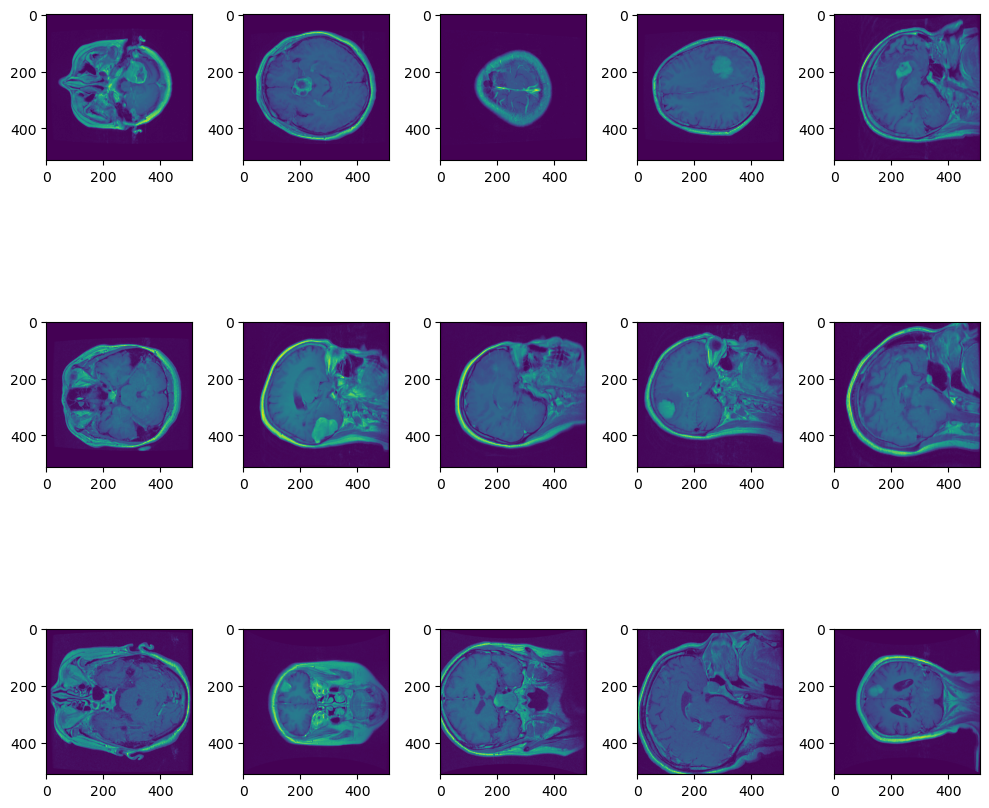

In [ ]:
images = [train_images[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
def create_model(num_filters, kernel_size, fc_neuron):
  ini_input=keras.Input(shape=(512,512,1),name="image")

  x1=layers.Conv2D(num_filters,(22,22),strides=2)(ini_input)
  x1=layers.MaxPooling2D((4,4))(x1)
  x1=layers.BatchNormalization()(x1)
  
  x2=layers.Conv2D(128,(11,11),strides=2,padding="same")(x1)
  x2=layers.MaxPooling2D((2,2))(x2)
  x2=layers.BatchNormalization()(x2)

  x3=layers.Conv2D(256,kernel_size,strides=2,padding="same")(x2)
  x3=layers.MaxPooling2D((2,2))(x3)
  x3=layers.BatchNormalization()(x3)

  x4=layers.Conv2D(512,(3,3),strides=2,padding="same")(x3)
  x4=layers.Flatten()(x4)
  x4=layers.Activation("relu")(x4)

  x5=layers.Dense(1024,"relu")(x4)

  x6=layers.Dense(256,"relu")(x5)

  x7=layers.Dense(fc_neuron,"relu")(x6)

  x9=layers.Dense(3)(x7)
  pred=layers.Activation("softmax")(x9)
  model = keras.Model(inputs=ini_input,outputs=pred) 
  model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
  return model

In [ ]:
num_generations = 3
population_size = 4
mutation_rate = 0.1

In [ ]:
def fitness_function(model, train_images, train_labels, test_images, test_labels):
    es = EarlyStopping(monitor='val_loss', patience=5)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
    #model.fit(train_images, train_labels, batch_size=32, epochs=5, validation_data=(test_images, test_labels), callbacks=[es, mc])
    model.fit(train_images,train_labels,epochs=10,batch_size=32,shuffle = False, validation_data=(test_images, test_labels),callbacks=[es, mc])
    loss, accuracy = model.evaluate(test_images, test_labels)
    return accuracy

In [ ]:
population = []
for i in range(population_size):
    num_filters = random.choice([32, 128])
    kernel_size = random.choice([(3, 3), (5, 5)])
    fc_neuron = random.choice([15,100,512])
    model = create_model(num_filters, kernel_size,fc_neuron)
    #model = create_model(num_filters)
    population.append(model)


In [ ]:
for i in range(num_generations):
    print('Generation:', i+1)
    fitness_scores = []
    for model in population:
        fitness_scores.append(fitness_function(model, train_images, train_labels, test_images, test_labels))

Generation: 1
Epoch 1/10
77/77 [==============================] - 13s 47ms/step - loss: 0.7472 - accuracy: 0.6626 - val_loss: 0.7095 - val_accuracy: 0.7096
Epoch 2/10
77/77 [==============================] - 2s 27ms/step - loss: 0.5464 - accuracy: 0.7443 - val_loss: 3.0263 - val_accuracy: 0.6281
Epoch 3/10
77/77 [==============================] - 2s 27ms/step - loss: 0.4216 - accuracy: 0.8071 - val_loss: 7.1293 - val_accuracy: 0.4666
Epoch 4/10
77/77 [==============================] - 2s 29ms/step - loss: 0.3703 - accuracy: 0.8461 - val_loss: 0.7219 - val_accuracy: 0.7439
Epoch 5/10
77/77 [==============================] - 2s 27ms/step - loss: 0.3306 - accuracy: 0.8580 - val_loss: 2.3069 - val_accuracy: 0.6476
Epoch 6/10
20/20 [==============================] - 0s 15ms/step - loss: 14.0296 - accuracy: 0.6150
Epoch 1/10
77/77 [==============================] - 7s 74ms/step - loss: 0.7027 - accuracy: 0.6642 - val_loss: 10.5968 - val_accuracy: 0.5628
Epoch 2/10
77/77 [====================

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = load_model('/content/best_model.h5')

In [ ]:
model.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 29ms/step - loss: 0.3163 - accuracy: 0.9266


[0.3162909150123596, 0.9265905618667603]

In [ ]:
label_pred_keras = model.predict(test_images)

20/20 [==============================] - 1s 27ms/step


In [ ]:
Pred_Label = np.argmax(label_pred_keras, axis=1)

ConfusionM = confusion_matrix(list(test_labels), Pred_Label, labels=[0, 1, 2])

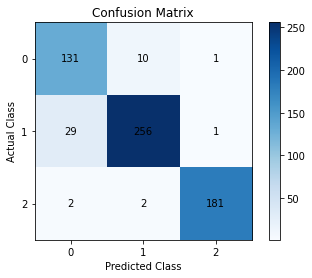

In [ ]:
plt.imshow(ConfusionM, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.xticks(np.arange(ConfusionM.shape[1]))
plt.yticks(np.arange(ConfusionM.shape[0]))
plt.grid(False)

for i in range(ConfusionM.shape[0]):
    for j in range(ConfusionM.shape[1]):
        plt.text(j, i, ConfusionM[i, j], ha='center', va='center', color='black')

plt.show()

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, Pred_Label)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, Pred_Label, average = 'weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, Pred_Label, average = 'micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, Pred_Label, average = 'micro')
print('F1 score: %f' % f1)

Accuracy: 0.926591
Precision: 0.931483
Recall: 0.926591
F1 score: 0.926591


In [ ]:
!cp "/content/best_model.h5" "/content/drive/MyDrive/model_files"